In [1]:
import pandas as pd
import os.path as op
from tqdm import tqdm
from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_prediction, stimulation_order, stimulation_palette
import seaborn as sns
import arviz as az
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np
import numpy as np
from bauer.models import FlexibleNoiseRiskRegressionModel
from tqdm import tqdm
import pingouin as pg

bids_folder = '/data/ds-tmsrisk'

# Some convenience functions
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):

    df = get_data(model_label=model_label, bids_folder=bids_folder)
    model = build_model(df=df, model_label=model_label)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

    return df, model, idata

bids_folder = '/data/ds-tmsrisk'

In [2]:
prf_pars = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_models', 'prf_parameters_thr.tsv'), sep='\t', index_col=[0,1,2,3]).droplevel(level=[1,2])
mean_prf_pars = prf_pars.groupby(['subject', 'stimulation_condition']).mean()

prf_diff = mean_prf_pars.unstack('stimulation_condition').swaplevel(axis=1)
prf_diff = prf_diff['ips'] - prf_diff['vertex']

In [ ]:
from tms_risk.cogmodels.fit_model import build_model, get_data

conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

model_label = 'flexible2'

df, model, idata = get_info(model_label)
model.build_estimation_model()
curves = model.get_sd_curve(conditions, idata=idata, x=np.arange(7, 50), variable='both', group=False)
mean_noise = curves.groupby(['stimulation_condition', 'x', 'subject']).mean()
sns.set(font_scale=1.6, font='Helvetica', style='white')
diff = mean_noise.xs(slice(7, 14), level='x', drop_level=False)['perceptual_noise_sd'].unstack('stimulation_condition')
diff = diff['ips'] - diff['vertex']
diff = diff.to_frame('cognitive_noise').groupby('subject').mean().merge(prf_diff.reset_index(), on='subject')

,n,r,CI95%,p-val,BF10,power
pearson,35,-0.379173,"[-1.0, -0.11]",0.01234,4.679,0.74081


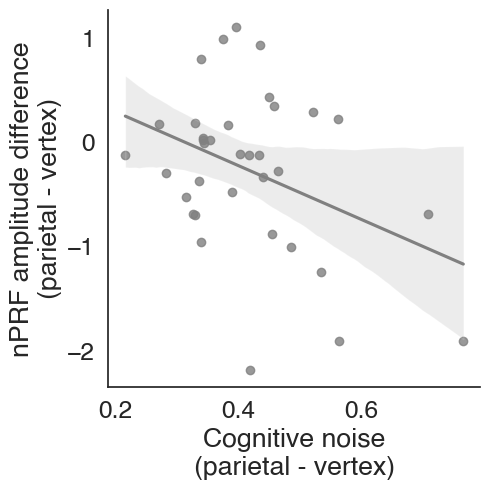

In [ ]:


display(pg.corr(x=diff['cognitive_noise'], y=diff['amplitude'], method='pearson', alternative='less'))

g = sns.lmplot(data=diff, x='cognitive_noise', y='amplitude', legend=False,     scatter_kws={'color': 'gray'},  line_kws={'color': 'gray'})     # Set regression line color to black

g.set(
    xlabel='Cognitive noise\n(parietal - vertex)',
    ylabel='nPRF amplitude difference\n(parietal - vertex)',
    title=None
)

g.savefig('/data/ds-tmsrisk/derivatives/figures/cognitive_noise_vs_amplitude.pdf', bbox_inches='tight')

,n,r,CI95%,p-val,BF10,power
pearson,35,-0.028848,"[-1.0, 0.26]",0.434669,0.24,0.069747


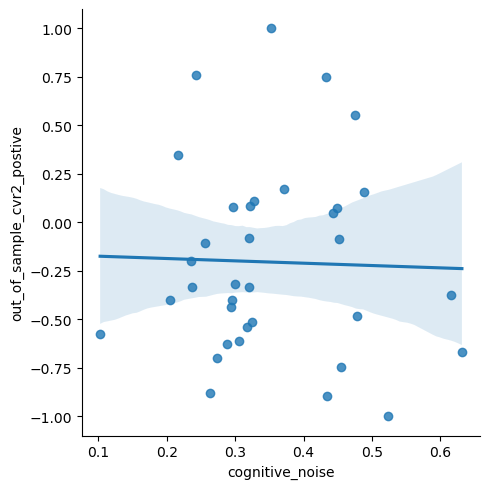

In [172]:
diff = mean_noise.xs(slice(7, 20), level='x', drop_level=False)['perceptual_noise_sd'].unstack('stimulation_condition')
diff = diff['ips'] - diff['vertex']
diff = diff.to_frame('cognitive_noise').groupby('subject').mean().merge(prf_diff.reset_index(), on='subject')

display(pg.corr(x=diff['cognitive_noise'], y=diff['out_of_sample_cvr2_postive'], method='pearson', alternative='less'))

sns.lmplot(data=diff, x='cognitive_noise', y='out_of_sample_cvr2_postive', palette=stimulation_palette, legend=False)



In [135]:
display(pg.corr(x=diff['cognitive_noise'], y=diff['amplitude'], method='bicor', alternative='less'))

,n,r,CI95%,p-val,power
bicor,35,-0.237684,"[-1.0, 0.05]",0.084583,0.400219


In [136]:
display(pg.corr(x=diff['cognitive_noise'], y=diff['amplitude'], method='spearman', alternative='less'))

,n,r,CI95%,p-val,power
spearman,35,-0.155742,"[-1.0, 0.13]",0.185824,0.229009


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39073/1970058911.py:1: UserWarning: 
The palette list has fewer values (2) than needed (35) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(data=mean_noise.stack().to_frame('value').reset_index(), hue='subject', x='x', y='value', style='stimulation_condition', col='variable', kind='line', palette=stimulation_palette)


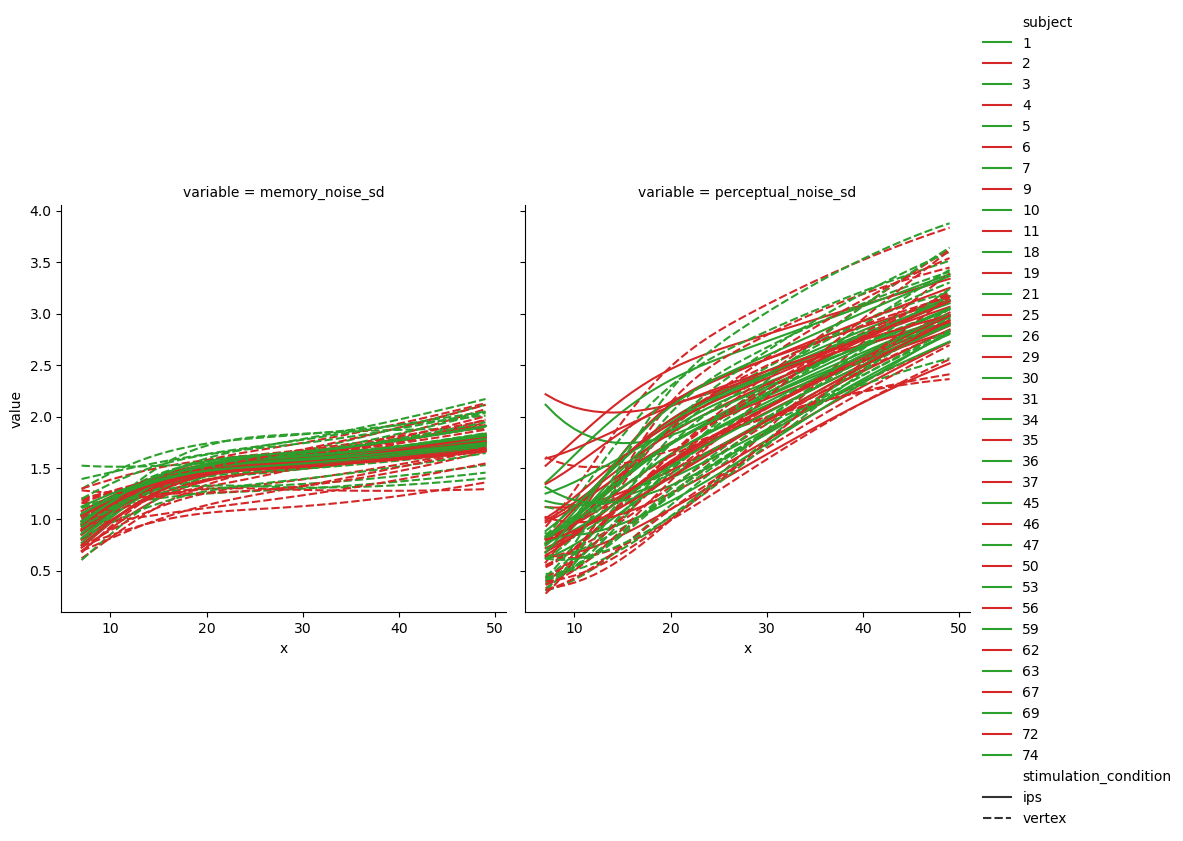

In [144]:
sns.relplot(data=mean_noise.stack().to_frame('value').reset_index(), hue='subject', x='x', y='value', style='stimulation_condition', col='variable', kind='line', palette=stimulation_palette)

In [150]:
diff = mean_noise.unstack('stimulation_condition').swaplevel(axis=1)
diff = diff['ips'] - diff['vertex']

diff.corr()

variable,memory_noise_sd,perceptual_noise_sd
variable,,
memory_noise_sd,1.000000,0.423771
perceptual_noise_sd,0.423771,1.000000


In [153]:
diff

variable    memory_noise_sd  perceptual_noise_sd
x  subject                                      
7  1              -0.081621             0.358327
   2              -0.100523             0.593017
   3              -0.247783             0.313891
   4              -0.111202             0.501168
   5               0.029000             0.347358
...                     ...                  ...
49 63              0.146528            -0.204347
   67             -0.430139            -0.633321
   69             -0.141579            -0.061313
   72             -0.024615            -0.225755
   74             -0.311525            -0.513145

[1505 rows x 2 columns]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39073/709547992.py:1: UserWarning: 
The palette list has fewer values (2) than needed (35) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(data=diff.stack().to_frame('value').reset_index(), hue='subject', x='x', y='value', kind='line', palette=stimulation_palette)


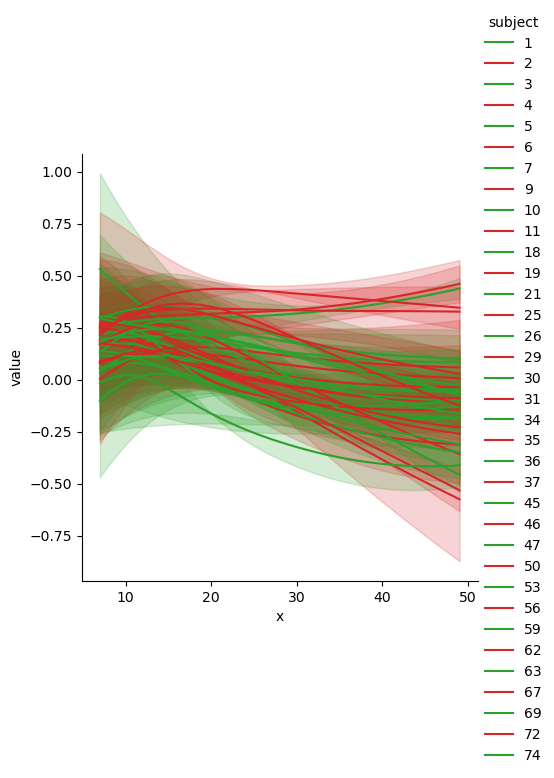

In [154]:
sns.relplot(data=diff.stack().to_frame('value').reset_index(), hue='subject', x='x', y='value', kind='line', palette=stimulation_palette) 

<Axes: xlabel='x,None'>

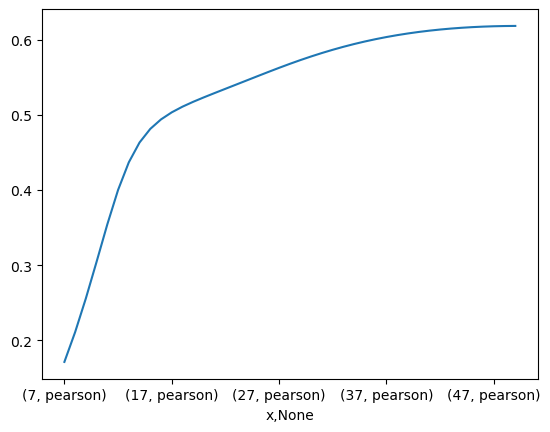

In [163]:
diff.groupby('x').apply(lambda x: pg.corr(x['memory_noise_sd'], x['perceptual_noise_sd'], method='pearson'))['r'].plot()

In [158]:
diff

variable    memory_noise_sd  perceptual_noise_sd
x  subject                                      
7  1              -0.081621             0.358327
   2              -0.100523             0.593017
   3              -0.247783             0.313891
   4              -0.111202             0.501168
   5               0.029000             0.347358
...                     ...                  ...
49 63              0.146528            -0.204347
   67             -0.430139            -0.633321
   69             -0.141579            -0.061313
   72             -0.024615            -0.225755
   74             -0.311525            -0.513145

[1505 rows x 2 columns]